In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from skimage import io

Summary of findings:
   
- distribution of number of times channels make it into trending is roughly gamma distributed. 
- Reliability: channels that make it into trending more often have less variance and upper bound in views.
- optimal number of tags.
- sentence length left skewed normal distribution.
- videos which trend longer went trending immediately.
- There is no leverage effect present. Just because a category is overcrowded doesn't mean new players can't get in.
- Videos which appear multiple times in trending tend to have part of the channel name in the video title.
- Like counts in trending videos are clustered in time (slowly decaying acf). 
- Different categories have different rankings of title sentiment with politics being significantly negative.

Some adventurous stuff:

- Analysis of common colours in video thumbnails.

In [10]:
youtube = pd.read_csv("youtube-new/GBvideos.csv")

In [22]:
id_to_category = {}

with open('youtube-new/GB_category_id.json' , 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
        
youtube['category'] = youtube['category_id'].astype(str).map(id_to_category)

In [87]:
youtube.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,Entertainment
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Music


### Channels

Distribution of the number of times a channel makes it into trending. It's roughly bimodal with the channels that only make it once being the external force on the system. These are viral videos.

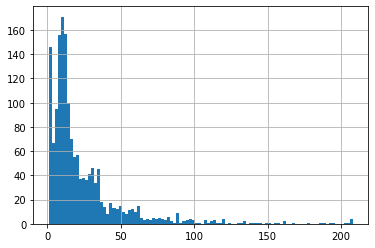

In [195]:
youtube['channel_title'].value_counts().hist(bins=100)

Channels that make it more often into trending have less variance in view numbers. (i should probably account for sample size)

In [229]:
d = youtube[['channel_title','views']].groupby('channel_title').agg(['count','mean'])['views']

In [230]:
d['mean'] = np.log(d['mean'])

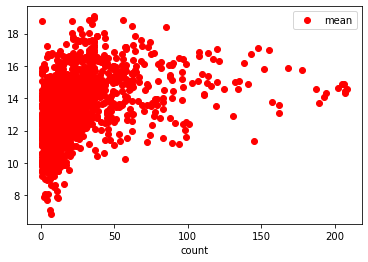

In [231]:
d.plot(x='count',y='mean', style='ro')

### Number of tags

It seems that having too many tags is a bad thing. It could indicate that viewers are disappointed. The oprimal number is likely around 10.

In [530]:
d = youtube['tags'].str.count('\|') + 1

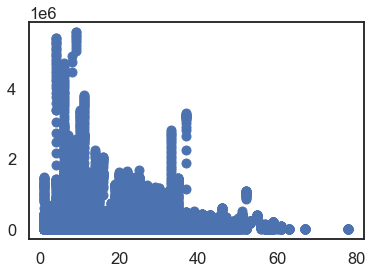

In [532]:
plt.plot(d.values,youtube['likes'].values,'bo')

### Sentence Length

Sentence length is left skewed with mean around 8 - 10

In [259]:
d = youtube['title'].str.count(' ') + 1

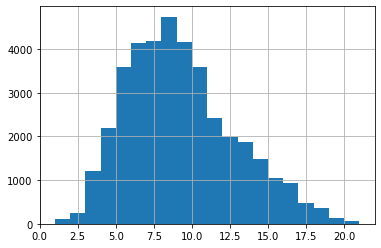

In [261]:
d.hist(bins=20)

In [264]:
d.mean()

8.755627505396237

### Days to trend vs trend duration

It is clear that videos which trend longer went trending immediately. 

In [336]:
youtube['publish_time'] = pd.to_datetime(youtube['publish_time'], format='%Y-%m-%d')

In [337]:
youtube['trending_date'] = pd.to_datetime(youtube['trending_date'],errors='coerce', format='%y.%d.%m')

In [338]:
publish_to_trend = (youtube['trending_date'].dt.date - youtube['publish_time'].dt.date).dt.days.values

In [339]:
d = youtube.groupby('video_id').agg({'trending_date':['first','last'], 'publish_time':'first'})

In [340]:
trending_duration = (d['trending_date']['last'] - d['trending_date']['first']).dt.days.values

In [361]:
publish_to_trend = (d['trending_date']['first'].dt.date-d['publish_time']['first'].dt.date).values

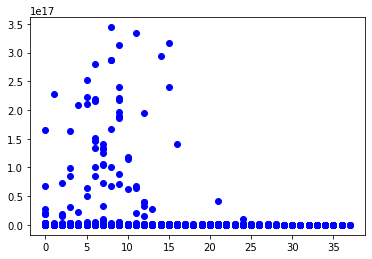

In [367]:
plt.plot(trending_duration,publish_to_trend,'bo')

### Engagement for different categories vs amount of content published (leverage)

Does a bigger market mean more competition and less views on average? no. 

In [188]:
d = youtube[['views','category']].groupby('category').agg(['count','mean'])

In [189]:
d = d['views']

In [191]:
d['mean'] = np.log(d['mean'])

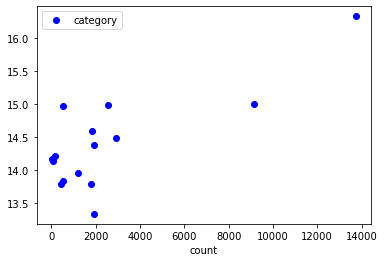

In [193]:
d.reset_index().plot(x='count',y='mean',style='bo',label='category')

### Part of the channel name is in the video title

This is a bad way of doing it but it is clear that videos which appear multiple times in trending tend to have part of the channel name in the video title.

In [ ]:
# find better way of doing this
c = []
for i in range(youtube.shape[0]):
    channel = youtube.iloc[i]['channel_title'].lower()
    title = youtube.iloc[i]['title'].lower().split(' ')
    c.append(sum([1 for w in title if w in channel]))

In [429]:
sum([1 for i in c if i == 0]), sum([1 for i in c if i > 0])

(17119, 21797)

In [476]:
youtube['channel_in_title'] = [i > 0 for i in c]

In [477]:
d = youtube[['channel_title', 'title','video_id','views','channel_in_title']].groupby('video_id').agg('first')

In [478]:
d = d[['channel_title','views','channel_in_title']].groupby('channel_title').agg(['count','mean'])

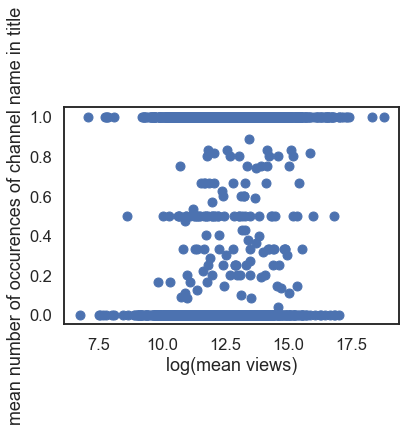

In [479]:
plt.plot(np.log(d['views']['mean']), d['channel_in_title']['mean'],'bo')
plt.xlabel('log(mean views)')
plt.ylabel('mean number of occurences of channel name in title')
plt.show()

In [480]:
d = youtube[['channel_title', 'title','video_id','channel_in_title']].groupby('video_id').agg('first')

In [481]:
d = d[['channel_title','channel_in_title']].groupby('channel_title').agg(['count','mean'])['channel_in_title']

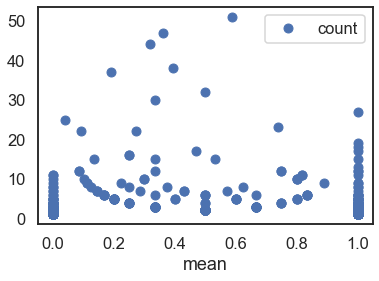

In [486]:
d.plot(x='mean',y='count',style='bo')

^ mean occurence of channel title in video title vs number of times the channel has appeared in trending

In [ ]:
youtube['publish_time'] = pd.to_datetime(youtube['publish_time'], format='%Y-%m-%d')
youtube['trending_date'] = pd.to_datetime(youtube['trending_date'],errors='coerce', format='%y.%d.%m')
publish_to_trend = (youtube['trending_date'].dt.date - youtube['publish_time'].dt.date).dt.days.values

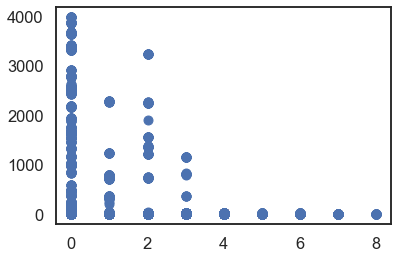

In [491]:
plt.plot(c,publish_to_trend,'bo')

### Slowly decaying autocorrelation function of likes

It seems that like counts in trending videos are clustered. (This is called short memory)

In [507]:
d = youtube.groupby('video_id').agg('last').sort_values(by=['publish_time'])['likes']

autocorrelation function:

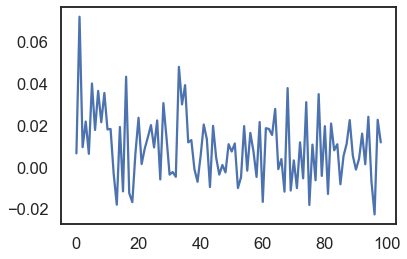

In [508]:
plt.plot([d.autocorr(N) for N in range(1,100)])

The clustering is best seen here:

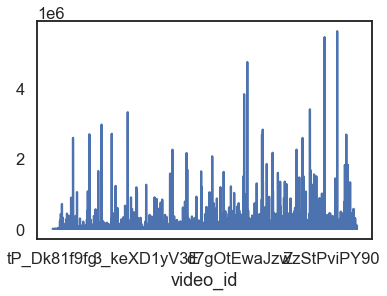

In [517]:
d.plot()

In [ ]:
### 

## Sentiment

Straight from Kaggle with little editing. It would be insightful to check whether more emotive words are used at the front of the title than the back.

In [391]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('vader_lexicon')
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0.5, 1.0, 'Polarity of Categories in Youtube videos')

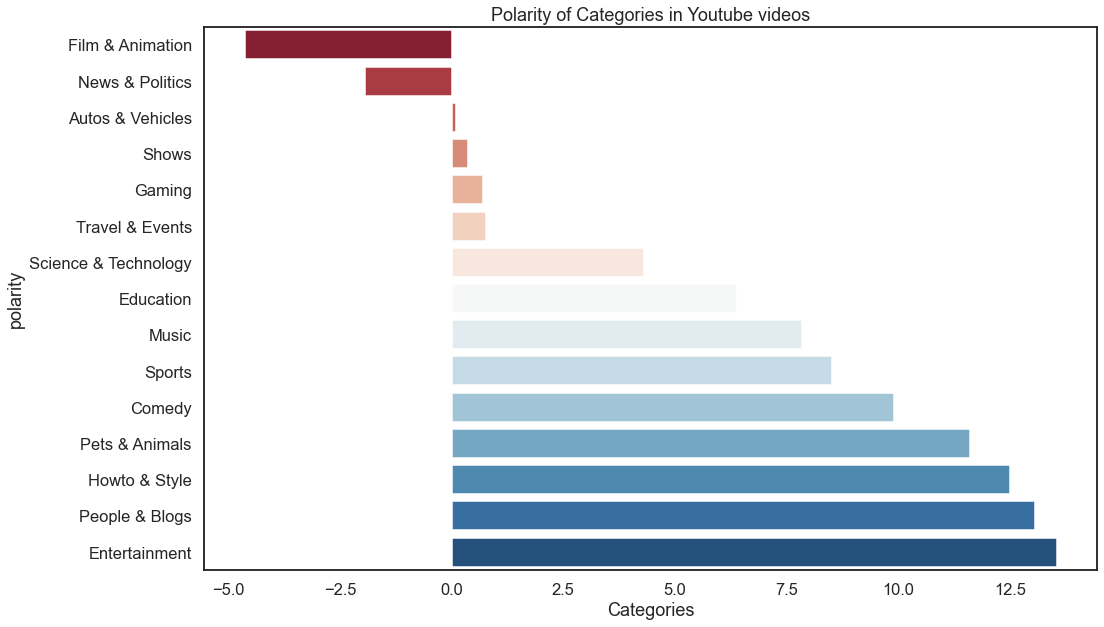

In [393]:
MAX_N = 1000 # make this bigger for a more reliable plot. takes longer though.

category_list = youtube['category'].unique()

#remove all the stopwords from the text
en_stopwords = list(stopwords.words('english'))
polarities = list()

for cate in category_list:
    tags_word = youtube[youtube['category']==cate]['tags'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]      
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)

category_list = pd.DataFrame(category_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list,polarities],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")


In [518]:
youtube['tags']

0        christmas|"john lewis christmas"|"john lewis"|...
1        SNL|"Saturday Night Live"|"SNL Season 43"|"Epi...
2        Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
3        Salford City FC|"Salford City"|"Salford"|"Clas...
4                                                   [none]
                               ...                        
38911    Enrique Iglesias feat. Pitbull|"MOVE TO MIAMI"...
38912    jacob sartorius|"jacob"|"up with it"|"jacob sa...
38913    anne|"marie"|"anne-marie"|"2002"|"two thousand...
38914    Eurovision Song Contest|"2018"|"Lisbon"|"Cypru...
38915    Kyle|"SuperDuperKyle"|"Ikuyo"|"2 Chainz"|"Soph...
Name: tags, Length: 38916, dtype: object

## Thumbnails

I've noticed a prevalence of (i) cinematic colours (ii) faces and (iii) text in thumbnails. We can crawl all such thumbnails and create hex colour, bool face, bool text features.

### Average colours

In [41]:
image = io.imread('https://i.ytimg.com/vi/n1WpP7iowLc/hqdefault.jpg')

The type of this input is <class 'numpy.ndarray'>
Shape: (360, 480, 3)


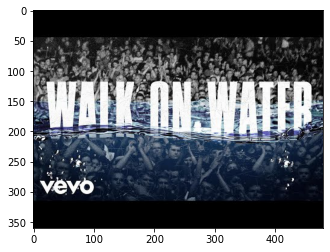

In [42]:
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

In [43]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [45]:
modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

In [84]:
clf = KMeans(n_clusters = 4)
labels = clf.fit_predict(modified_image)

[array([ 6.42041285,  8.80043562, 13.38875332]), array([239.93262872, 242.18371885, 243.61442721]), array([124.65818182, 132.68879051, 143.46166008]), array([46.97649762, 57.46462758, 73.50757528])]


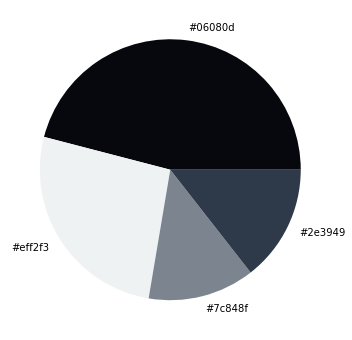

In [85]:
counts = Counter(labels)

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

plt.figure(figsize = (8, 6))
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

print(rgb_colors)

In [79]:
def f():
    image = io.imread('https://i.ytimg.com/vi/n1WpP7iowLc/hqdefault.jpg')
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    clf = KMeans(n_clusters = 1)
    labels = clf.fit_predict(modified_image)
    counts = Counter(labels)
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    return ordered_colors

In [80]:
%time
ordered_colors = f()

Wall time: 0 ns


In [81]:
ordered_colors

[array([66.35646667, 71.594225  , 79.55349583])]

### Text in thumbnail

Often, there is text embedded in the thumbail image.

### Faces

Often, there are human faces in the thumbnail to attract attention.